# ML.py, MLpy, MLPy!
<p style="text-align: center;">MLpy came as a simple question <i>and</i> a big project in pespective:
<br><b>"Can I build a discord bot that can tell two pictures apart?"</b></p>
<br>The goal of this notebook is two-fold with one overarching thread:

1. To build a web crawler that can lift a statistically relevant number of images from [derpibooru](https://derpibooru.org), an image database powered by the community that built around the fourth generation of the show 'My Little Pony.'
2. To build a machine learning algorithm capable of telling the difference between 2 types of pictures--to be summarized in a function that I can feed to my existing discord bot [BotJack](https://github.com/LMquentinLR/botjack_discord_bot).

The thread is that I am, at the time of writing, learning how to program. I neither know how to build a web crawler or how a ML algorithm works (is it even called an algorithm?). All in all, this is a small idea that is both a learning experience, a blog--and of course a fun project.

### Why a bot should do that?
There are many reasons why a bot should be able to identify images posted on a server: classification, tagging, games, etc. 
<p style="text-align: center;"><br>This notebook will focus on <b>compliance</b>.</p> 

* Servers may have anti-NSFW (i.e. not safe for watch) rules where explicit, grim, and otherwise unwanted content is banned or curtailed to specific server channels.
* Moderation being volunteer-driven on discord, malicious users may capitalize on idle, asleep, or away-from-keyboard moderators to engage in rule-breaking activities. More commonly, users may simply post a NSFW picture in a SFW-only channel. 
* A bot able to distinguish NSFW content from SFW helps fill in the breaches that may affect any moderation effort. A bot, for instance, could automatically alert moderators when a specific content is posted and start a moderating process prior to any human intervention.

<b>Automatic content moderation and compliance is a current industry effort in social media (e.g. Facebook)</b>, making this notebook a real world application.

In [1]:
#import imageio
import json
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import operator
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import random
from random import shuffle
import shutil
import time

Using TensorFlow backend.


### Building a web crawler
Derpibooru is a website dedicated to fanart of MLP:FiM. It provides a JSON REST API for major site functionality, which can be freely used by anyone wanting to produce tools for the site or other webapps that use the data provided within Derpibooru.
<br><b>Derpibooru licensing rules</b>
<br>"<i>Anyone can use it, users making abusively high numbers of requests may be asked to stop. Your application MUST properly cache, respect server-side cache expiry times. Your client MUST gracefully back off if requests fail (eg non-200 HTTP code), preferably exponentially or fatally.</i>"

<br>A single image can be accessed through the following links:
1. https://derpibooru.org/2072316 (embedded)
2. https://derpicdn.net/img/view/2019/6/22/2072316.png (default size)
3. https://derpicdn.net/img/view/2019/6/22/2072316_small.png (small size)
4. https://derpicdn.net/img/view/2019/6/22/2072316_medium.png (medium size)
5. https://derpicdn.net/img/view/2019/6/22/2072316_large.png (large size)

The metadata of a single picture can be accessed through the following link:
* https://derpibooru.org/2072316.json
<br> The list of attributes a single image is:
>id, created_at, updated_at, first_seen_at, score, comment_count, width, height, file_name, description, uploader, uploader_id, image, upvotes, downvotes, faves, tags, tag_ids, aspect_ratio, original_format, mime_type, sha512_hash, orig_sha512_hash, source_url, representations, is_rendered, is_optimized, interactions, spoilered

In [2]:
class img_metadata:
    """
    Class object that corresponds to the process retrieving picture metadata from the REST API
    of the website derpibooru--data is retrieved as a series of est. 1Mb JSON files.
    """
    
    def __init__(self, tags = "", at_least_one = True, instances = 10, machine_learning = False):
        """
        Initializes of the img_metadata class object.
        ---
        :param <self>:             <class>   ; class object reference
        :param <tags>:             <list>    ; list of strings (i.e. picture tags)
        :param <at_least_one>:     <boolean> ; toggles 'at least one tag' option instead of 'all tags'
        :param <instances>:        <integer> ; number of instances/loops allowed before program stops
        :param <machine_learning>: <boolean> ; toggles retrieving thumbnails instead of large pictures
        """
        self.tags = tags
        self.at_least_one = at_least_one
        self.instances = instances
        self.machine_learning = machine_learning
    
    def convert_bytes(self, bytes_size):
        """
        Converts byte lengths.
        ---
        :param <self>:       <class>   ; class object reference
        :param <bytes_size>: <integer> ; size in bytes of a file
        """
        for unit_multiple in ['bytes', 'KB', 'MB', 'GB', 'TB']:
            if bytes_size < 1024.0:
                return "%3.1f %s" % (bytes_size, unit_multiple)
            bytes_size /= 1024.0
    
    def keys_to_keep(self):
        """
        Returns the keys to keep in the JSON extract.
        ---
        :param <self>: <class> ; class object reference
        """
        keys = ["id", "created_at", "updated_at", "score", "uploader",
                "uploader_id", "upvotes", "downvotes", "faves", "tags",
                "tags_id", "aspect_ratio", "representations"]
        return keys
    
    def json_split(self, path):
        """
        Splits a json file if it is too large (1Mb).
        ---
        :param <self>: <class>  ; class object reference
        :param <path>: <string> ; path of a json file
        """
        length = self.convert_bytes(float(os.stat(path).st_size))
        length = length.split(" ")
        if float(length[0]) >= 1.0 and length[1] == "MB":
            nb_file = 0
            while True:
                new_path = path[:-5] + "_" + str(nb_file) + ".json"
                if os.path.exists(new_path) == False:
                    print("SPLIT: JSON file to be split as 1Mb max size reached.")
                    os.rename(path, new_path) 
                    break
                nb_file += 1
    
    def check_prior_extract(self, print_msg = True):
        """
        Checks existing metadata extractions in the working directory. 
        The default file name is 'derpibooru_metadata.json'.
        ---
        :param <self>:      <class>   ; class object reference
        :param <print_msg>: <boolean> ; toggle between 'prints message to command line' and 'prints nothing'
        """
        
        json_found = "FOUND: 'derpibooru_metadata.json'"
        json_not_found = "MISSING FILE: 'derpibooru_metadata.json'; NOT IN: folder 'data'\n" + \
                         "FILE TO CREATE: 'derpibooru_metadata.json'"
        json_created = "FILE CREATED: 'derpibooru_metadata.json'"
        json_not_created = "ERROR FILE CREATION: 'derpibooru_metadata.json'"
        json_path = os.getcwd() + "\\data\\derpibooru_metadata.json"
        
        find = os.path.exists(json_path)
        
        #if TRUE: opens file and extracts the contained metadata
        #if FALSE: creates file storing an empty list
        if find:
            if print_msg: print(json_found)
        else:
            if print_msg: print(json_not_found)
            try:    
                with open(json_path, "w") as file: file.write("[]")   
                print(json_created) 
            except Exception as e: print(json_not_created, e, sep = "\n")
        
        return json_path

    def crawl_metadata(self):
        """
        Retrieves from the derpibooru REST API a list of picture metadata.
        ---
        :param <self>: <class> ; class object reference
        """
        #initializes local variables    
        iterations = self.instances
        back_off_counter = 1
        max_instances_reached = "The set maximum number of images to request was reached " + \
                                f"at {self.instances}."
        exit_condition = "The crawler scraped the derpibooru metadata. The program will " + \
                         "now close."
        
        #retrieves most recent recorded picture id
        if os.path.exists(os.getcwd() + "\\data\\derpibooru_metadata.json"): 
            json_path = os.getcwd() + "\\data\\derpibooru_metadata.json"
        else: 
            json_path = self.check_prior_extract()
        
        with open(json_path, "r") as file: requested_id = json.load(file)
        
        if requested_id == []: requested_id = 1
        else: requested_id = requested_id[0]["id"] + 1
        
        while True:
            requested_page = "You are requesting the derpibooru page starting with the " + \
                             f"id {requested_id}."
            error_json_extraction = "The program couldn't extract the page and " + \
                                    "will now proceed to an exponential back off."
            
            #checks if previous JSON was not renamed due to the 1Mb splitting
            json_path = self.check_prior_extract(False)
            
            with open(json_path,'r') as file: json_local = json.load(file)
            
            print(requested_page)
            
            path_derpibooru = "https://derpibooru.org/images.json?constraint=id&order=a&gt=" + \
                              str(requested_id)
            
            try:
                if type(iterations) == int:
                    if iterations > 1: iterations -= 1
                    else: break
                
                json_derpibooru = requests.get(path_derpibooru).json()["images"]
                if json_derpibooru == []: raise DatabaseFullyCrawled
                
                requested_id = self.json_collect(json_local, json_derpibooru, json_path)
                
                #time delay to respect the API's license
                time.sleep(.250)
            
            except DatabaseFullyCrawled:
                print(exit_condition)
                break
            
            except Exception as e:
                print(e)
                print(error_json_extraction)
                print(f"The error was the following: {e}.\n The program will back " + \
                      f"off for {2**back_off_counter} seconds.")
                back_off_counter += 1
                time.sleep(2 ** back_off_counter)

    def json_collect(self, json_local, json_derpibooru, json_path):
        """
        Collects picture metadata extracted from derpibooru.
        ---
        :param <self>:            <class>       ; class object reference
        :param <json_local>:      <json_object> ; JSON data stored locally
        :param <json_derpibooru>: <json_object> ; JSON data extracted from derpibooru
        :param <json_path>:       <string>      ; path of local file where the data is stored
        """
        stored_keys = self.keys_to_keep()
        last_id = -1
        
        for image_data in json_derpibooru:
            
            temp = image_data.copy()
            
            for item in image_data: 
                if item not in stored_keys: del temp[item]
            
            last_id = max(image_data["id"], last_id)
            
            json_local.append(temp)
            json_local.sort(key=operator.itemgetter("id"), reverse = True)

        with open(json_path,'w') as file: json.dump(json_local, file)
        
        self.json_split(json_path)
        
        return last_id
    
    def id_filter(self, tags, at_least_one, machine_learning = False):
        """
        Retrieves the IDs of the locally stored metadata that fit specific tag parameters
        ---
        :param <self>:             <class>   ; class object reference
        :param <tags>:             <list>    ; list of strings (i.e. picture tags)
        :param <at_least_one>:     <boolean> ; toggles 'at least one tag' option instead of 'all tags'
        :param <machine_learning>: <boolean> ; toggles retrieving thumbnails instead of large pictures
        """
        def any_or_all(boolean):
            """
            Returns the function any() if argument <boolean> TRUE, else returns function all()
            ---
            :param <boolean>: <boolean> ; boolean value
            """
            if boolean == True:
                return any
            else:
                return all
        
        metadata_files_list = filter(lambda file: file.startswith("derpibooru_metadata"), 
                                     os.listdir(os.getcwd() + "\\data"))
        metadata_files_list = list(metadata_files_list)
        
        id_list = []
        url_list = []
        
        for fname in metadata_files_list:
            
            with open(os.getcwd() + "\\data\\" + fname,"r") as file: json_local = json.load(file)
            if json_local == []: break
            
            tags_keep = list(filter(lambda item: item.startswith("+"), tags))
            tags_keep = list(map(lambda item: item[1:], tags_keep))
            tags_remove = list(filter(lambda item: item.startswith("-"), tags))
            tags_remove = list(map(lambda item: item[1:], tags_remove))
            
            fltr = any_or_all(at_least_one)
            filter_keep = lambda item: fltr(tag in item["tags"].split(", ") for tag in tags_keep)
            filter_remove = lambda item: not any(tag in item["tags"].split(", ") for tag in tags_remove)
            json_kept = list(filter(filter_keep, json_local))
            json_kept = list(filter(filter_remove, json_kept))
            
            filter_id = lambda item: item["id"]
            if not machine_learning:
                filter_url = lambda item: item["representations"]["large"][2:]
            else:
                filter_url = lambda item: item["representations"]["thumb_small"][2:]
            id_list += list(map(filter_id, json_kept))
            url_list += list(map(filter_url, json_kept))
            
        return list(zip(id_list, url_list))
    
    def repair_tags(self):
        """
        Checks if all retrieved IDs have an available list of tags.
        ---
        :param <self>: <class> ; class object reference
        """
        metadata_files_list = filter(lambda file: file.startswith("derpibooru_metadata"), 
                                     os.listdir(os.getcwd() + "\\data"))
        metadata_files_list = list(metadata_files_list)
        
        for fname in metadata_files_list:
            
            with open(os.getcwd() + "\\data\\" + fname, "r") as file: 
                
                json_local = json.load(file)
                if json_local == []:break
                
                for index, item in enumerate(json_local):

                    if item["tags"] == None:
                        json_id = item["id"]
                        path_derpibooru = "https://derpibooru.org/" + str(json_id) + ".json"

                        try:
                            json_derpibooru = requests.get(path_derpibooru).json()
                            time.sleep(.250)
                            if json_derpibooru["tags"] == None: raise AbsentTagList
                            json_local[index]["tags"] = json_derpibooru["tags"]
                            print(f"The tags of the picture {json_id} were updated.")

                        except AbsentTagList:
                            print(f"The url request for the picture {json_id} returned an empty list of tags.")

                        except Exception as e:
                            print(e)
                
            with open(os.getcwd() + "\\data\\" + fname,'w') as file: json.dump(json_local, file)

In [3]:
class derpibooru_search(img_metadata):
    """
    Class object that corresponds to a search prompting the derpibooru REST API and
    retrieve both picture metadata and the affiliated pictures.
    """
    
    def change_search(self, tags = "", at_least_one = True, instances = 10, machine_learning = False):
        """
        Changes the arguments of the created object derpibooru_search.
        ---
        :param <self>:             <class>   ; class object reference
        :param <tags>:             <list>    ; list of strings (i.e. picture tags)
        :param <at_least_one>:     <boolean> ; toggles 'at least one tag' option instead of 'all tags'
        :param <instances>:        <integer> ; number of instances/loops allowed before program stops
        :param <machine_learning>: <boolean> ; toggles retrieving thumbnails instead of large pictures
        """
        self.tags = tags
        self.at_least_one = at_least_one
        self.instances = instances
        self.machine_learning = machine_learning

    def crawl(self):
        """
        Changes the arguments of the created object derpibooru_search.
        ---
        :param <self>: <class> ; class object reference
        """
        print("----|Entering Derpibooru Data Crawler code|----")
        self.crawl_metadata()
        print("---------------|Exiting Program|---------------")
    
    def retrieve_ids(self):
        """
        Retrieves the IDs of the locally stored metadata that fit specific tag parameters.
        ---
        :param <self>: <class> ; class object reference
        """
        print("----|Retrieving IDs based on tag selection|----")
        id_list = self.id_filter(self.tags, self.at_least_one, self.machine_learning)
        print("----------------|IDs retrieved|----------------")
        return id_list
    
    def repair(self):
        """
        Repairs missing tags of the locally stored metadata.
        ---
        :param <self>: <class> ; class object reference
        """
        print("----|Repairing missing tags in stored JSON|----")
        self.repair_tags()
        print("----------------|Tags repaired|----------------")

    def request_imgs(self, tags, id_list, nb_of_requests = None):
        """
        Retrieves a number of images from derpibooru.
        ---
        :param <self>:           <class>   ; class object reference
        :param <tags>:           <list>    ; list of strings (tags used to search ids)
        :param <id_list>:        <list>    ; list of strings (i.e. picture id + url)
        :param <nb_of_requests>: <integer> ; number of images to request
        """
        print("------|Requesting images from derpribooru|-----")
        
        assert isinstance(tags, list) and isinstance(id_list, list) and isinstance(nb_of_requests, int)
        
        img_path = os.getcwd() + "\\data\\" + "".join(sorted(tags))
        if not os.path.exists(img_path): os.mkdir(img_path)
        
        for index, item in enumerate(id_list):
            
            image_id = str(item[0])
            path_derpibooru = item[1]
            extension = "." + path_derpibooru.split(".")[-1]
            
            if index > nb_of_requests: 
                break
            
            picture_path = img_path + "\\" + image_id
            if os.path.exists(picture_path + ".png"): 
                continue
            
            if not item[1].endswith(("png")):
                nb_of_requests += 1
                continue

            try:
                picture_path += extension
                request = requests.get("http://" + path_derpibooru)
                if request.status_code == 200:
                    with open(picture_path, 'wb') as f:
                        f.write(request.content)
                
                time.sleep(.5)
                
                print(f"The picture {image_id} was downloaded.")

            except Exception as e:
                print(e)
            
        print("---------------|Images retrieved|--------------")

In [4]:
class Error(Exception):
    """Base class for other exceptions"""
    pass

class DatabaseFullyCrawled(Error):
    """Raised when the crawler reached the last pages of derpibooru"""
    pass

class NewContentCrawled(Error):
    """Raised when the input value is too large"""
    pass

class AbsentTagList(Error):
    """Raised when the key value of the key 'tags' in a dictionary is 'None'"""
    pass

------------------

## Initializing object

In [ ]:
obj = derpibooru_search()

## Crawling
1. Test #1 would retrieve all existing available picture metadata but will stop at the 10th requested page
2. Test #2 will retrieve all existing available picture metadata (can take up to 60h as at July 2019)

In [ ]:
obj.__dict__
obj.change_search(instances = 10)
obj.crawl()

In [ ]:
obj.__dict__
obj.change_search(instances = "")
obj.crawl()

Sometimes, retrieved metadata would be missing their tags. The following repairs them.

In [ ]:
obj.repair()

## Retrieving IDs based on tag selection

This version of the search function takes a list of strings which must match the following format:
<br><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"+tag" <i>or</i> "-tag"
<br><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>+</b> indicates keeping the ID for search, <b>-</b> indicates removing the ID for search.
<br><br>The [at_least_one] variable indicates:
1. if TRUE: the retrieved IDs will <b>only</b> be the ones which tags <b>contain at least one</b> of the items listed in the variable [tags] with a "+" prefix
2. if FALSE: the retrieved IDs will <b>only</b> be the ones which tags <b>contain all</b> of the items listed in the variable [tags]

In [ ]:
search_tags = ["+safe"]
search_include = False
obj.change_search(tags = search_tags, at_least_one = search_include, machine_learning = False)

In [ ]:
id_list = obj.retrieve_ids()

print(len(id_list))
print(type(id_list))
print("\nFirst five items retrieved:")
print(id_list[:5])

### Retrieving pictures based on retrieved IDs

In [ ]:
nb_of_requests = len(id_list)

In [ ]:
obj.request_imgs(search_tags, id_list, 1)

## DATA EXPLORATION USING NUMPY, MATPLOLIB, PANDAS, GGPLOT2, PLOTLY, BOKEH

### What do we want to plot?

1. number of pictures posted across time that fit the tag "Rarijack"
2. 

In [ ]:
search_tags = ["+rarijack"]
search_include = True
obj.change_search(tags = search_tags, 
                  at_least_one = search_include, 
                  machine_learning = False)
id_list = obj.retrieve_ids()

### Numpy

### MatplotLib

### Pandas

### Ggplot2

### Plotly

### Bokeh

# EXAMPLE 1 - SEPARATING SFW FROM NSFW PICTURES

## Downloading pictures

We need to download a set of pictures which can be used to fit a machine learning model.

In [ ]:
def download(tags):
    """
    Downloads pictures based on a list of tag.
    ---
    :param <tags>: list ; list of tags to sort and download pictures
    """
    obj = derpibooru_search()
    obj.change_search(tags = tags, at_least_one = True, machine_learning = True)
    id_list = obj.retrieve_ids()
    obj.request_imgs(tags, id_list, 80000)

In [ ]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "-comic", "-meme", "-text"]]

for tag in tags:
    download(tag)

## Cleaning extracted pictures

The retrieved pictures are all sized differently and some are unusable. We need to resize them and clean the folders from the unreadable data.

In [ ]:
def clean_pictures(targets):
    """
    Cleans the pictures that will be used for training and validation.
    ---
    :param <targets>: list ; list of folders to clean
    """
    for folder in target_folders:
        img_content = os.listdir(folder)
        to_delete = []
        for img in img_content:
            if img[-4:] != "jpeg":
                try:
                    image = Image.open(folder + "/" + img)
                    if 0.7 < image.size[0]/image.size[1] < 1.4:
                        image = image.resize((224, 224))
                        image.save(folder + "/" + img)
                    else:
                        image.close()
                        os.remove(folder + "/" + img)
                except Exception as e:
                    print(e)
                    os.remove(folder + "/" + img)

The downloaded pictures have been <b>manually</b> copied in "copy" folders to avoid overwriting them.

In [ ]:
target_folders = ["./data/+safe-copy", "./data/+unsafe-copy"]
clean_pictures(target_folders)

## Running Machine Learning

### Creating samples

Based on all the extracted pictures--and to make the process run in a timely manner on my Surface Pro 2--we are sampling the extracted data:

- 1000 safe and unsafe pictures for training
- 100 safe and unsafe pictures for testing/validation

In [5]:
def create_sample(folders, sample_desc):
    """
    Samples existing pictures.
    ---
    :param <folders>: list ; list of folders to sample
    :param <sample_desc>: list ; list of folders where to store samples 
                                 + nb of pictures to extract
    """
    for model in model_description:
        target_folder = model[0]
        try:
            shutil.rmtree(target_folder)
        except Exception as e: 
            print(e)
        os.makedirs(target_folder)
        
        selection = []
        
        for folder in folders:
            counter = 0
            stored_imgs = os.listdir(folder)
            
            while counter != model[1]:
                choice = random.choice(stored_imgs)
                if choice not in selection:
                    selection.append(choice)
                    shutil.copy(folder + "/" + choice, target_folder)
                    os.rename(target_folder + "/" + choice,
                             target_folder + "/" + folder[7:].split("-")[0]
                             + "-" + choice)
                    counter += 1

In [7]:
folders = ["./data/+safe-copy", "./data/+unsafe-copy"]
#model_description = [("./data/Training", 500), 
#                     ("./data/Validation", 100), 
#                     ("./data/Test", 200)]
model_description = [("./data/Training", 1000),
                     ("./data/Test", 100)]

create_sample(folders, model_description)

The code below is a rewrite of the following github: [here](https://github.com/CShorten/KaggleDogBreedChallenge/blob/master/DogBreed_BinaryClassification.ipynb?source=post_page---------------------------).
Thanks to CShorten!

In [8]:
def label_img(name):
    """
    Returns whether an image is safe or unsafe based on its name.
    ---
    :param <name>: string ; path/name of a picture
    """
    word_label = name.split('-')[0]
    if word_label.startswith("+safe"): return np.array([1, 0])
    else: return np.array([0, 1])

def load_data(folder):
    """
    Loads the safe/unsafe value of each picture stored in a specific folder.
    ---
    :param <filder>: string ; path of a folder
    """
    test_data = []
    for img in os.listdir(folder):
        label = label_img(img)
        path = os.path.join(folder, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((224, 224), Image.ANTIALIAS)
        test_data.append([np.array(img), label])
    shuffle(test_data)
    return test_data

In [9]:
model_description = [("./data/Training", 1000),
                     ("./data/Test", 100)]
DIR_TRAINING = model_description[0][0]
DIR_TESTING = model_description[1][0]

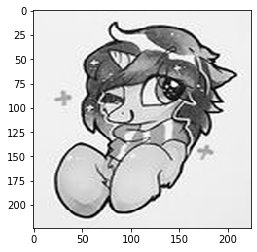

In [49]:
train_data = load_data(DIR_TRAINING)
plt.imshow(train_data[1][0], cmap = 'gist_gray')

trainImages = np.array([i[0] for i in train_data]).reshape(-1, 224, 224, 1)
trainLabels = np.array([i[1] for i in train_data])

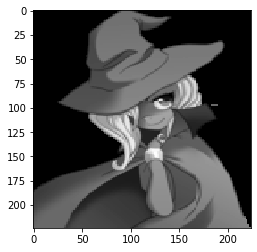

In [48]:
test_data = load_data(DIR_TESTING)    
plt.imshow(test_data[1][0], cmap = 'gist_gray')

testImages = np.array([i[0] for i in test_data]).reshape(-1, 224, 224, 1)
testLabels = np.array([i[1] for i in test_data])

### Machine Learning Modeling - TEST 1

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

W0807 02:23:18.869405  3644 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 02:23:18.915321  3644 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 02:23:18.927299  3644 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 02:23:18.965729  3644 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

In [13]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

W0807 02:23:19.945408  3644 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 02:23:20.002303  3644 deprecation.py:323] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
2000/2000 [==============================] - 278s 139ms/step - loss: 0.8572 - acc: 0.5275
Epoch 2/20
2000/2000 [==============================] - 271s 135ms/step - loss: 0.6873 - acc: 0.6130
Epoch 3/20
2000/2000 [==============================] - 284s 142ms/step - loss: 0.6225 - acc: 0.6720
Epoch 4/20
2000/2000 [==============================] - 266s 133ms/step - loss: 0.5520 - acc: 0.7115
Epoch 5/20
2000/2000 [==============================] - 261s 130ms/step - loss: 0.4853 - acc: 0.7675
Epoch 6/20
2000/2000 [==============================] - 257s 128ms/step - loss: 0.4372 - acc: 0.8005
Epoch 7/20
2000/2000 [==============================] - 255s 128ms/step - loss: 0.3726 - acc: 0.8330
Epoch 8/20
2000/2000 [==============================] - 255s 127ms/step - loss: 0.3242 - acc: 0.8495
Epoch 9/20
2000/2000 [==============================] - 267s 133ms/step - loss: 0.2682 - acc: 0.8830
Epoch 10/20
2000/2000 [==============================] - 258s 129ms/step - loss: 0.2327 - a

In [15]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

71.0


As at August 7th, the prediction power of the model over the test sample is of 71%

In [16]:
model.save('NSFWdetector_20e100bs_v1.h5')

### Training an already trained model

1000 new safe and unsafe pictures have been sampled for training, along with 100 new safe and unsafe pictures for testing.

In [17]:
model = load_model('NSFWdetector_20e100bs_v1.h5')

In [18]:
folders = ["./data/+safe-copy", "./data/+unsafe-copy"]
#model_description = [("./data/Training", 500), 
#                     ("./data/Validation", 100), 
#                     ("./data/Test", 200)]
model_description = [("./data/Training", 1000),
                     ("./data/Test", 100)]

create_sample(folders, model_description)

In [19]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
2000/2000 [==============================] - 271s 136ms/step - loss: 0.0559 - acc: 0.9790
Epoch 2/20
2000/2000 [==============================] - 263s 131ms/step - loss: 0.0490 - acc: 0.9845
Epoch 3/20
2000/2000 [==============================] - 255s 128ms/step - loss: 0.0417 - acc: 0.9845
Epoch 4/20
2000/2000 [==============================] - 258s 129ms/step - loss: 0.0488 - acc: 0.9820
Epoch 5/20
2000/2000 [==============================] - 252s 126ms/step - loss: 0.0545 - acc: 0.9815
Epoch 6/20
2000/2000 [==============================] - 251s 126ms/step - loss: 0.0694 - acc: 0.9760
Epoch 7/20
2000/2000 [==============================] - 253s 126ms/step - loss: 0.0556 - acc: 0.9805
Epoch 8/20
2000/2000 [==============================] - 259s 130ms/step - loss: 0.0712 - acc: 0.9765
Epoch 9/20
2000/2000 [==============================] - 255s 128ms/step - loss: 0.0535 - acc: 0.9815
Epoch 10/20
2000/2000 [==============================] - 257s 129ms/step - loss: 0.0494 - a

In [20]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

70.0


As at August 7th, training the first version of the model again worsens the prediction power of the model over a test sample by 100 basis points. <b>This is a potential case of overfitting</b>.

In [21]:
model.save('NSFWdetector_20e100bs_v2.h5')

### Machine Learning Modeling - TEST 2

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

In [23]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

In [24]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
2000/2000 [==============================] - 298s 149ms/step - loss: 1.3156 - acc: 0.5580
Epoch 2/20
2000/2000 [==============================] - 300s 150ms/step - loss: 0.8413 - acc: 0.6475
Epoch 3/20
2000/2000 [==============================] - 299s 149ms/step - loss: 0.6305 - acc: 0.7160
Epoch 4/20
2000/2000 [==============================] - 303s 152ms/step - loss: 0.4408 - acc: 0.8060
Epoch 5/20
2000/2000 [==============================] - 304s 152ms/step - loss: 0.3082 - acc: 0.8755
Epoch 6/20
2000/2000 [==============================] - 304s 152ms/step - loss: 0.2210 - acc: 0.9260
Epoch 7/20
2000/2000 [==============================] - 308s 154ms/step - loss: 0.1674 - acc: 0.9395
Epoch 8/20
2000/2000 [==============================] - 307s 153ms/step - loss: 0.1175 - acc: 0.9590
Epoch 9/20
2000/2000 [==============================] - 306s 153ms/step - loss: 0.0850 - acc: 0.9735
Epoch 10/20
2000/2000 [==============================] - 309s 154ms/step - loss: 0.0895 - a

In [25]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

71.0


As at August 7th, the prediction power of the model over the test sample is of 71%

In [26]:
model.save('NSFWdetector_20e100bs_v3.h5')

### Machine Learning Modeling - TEST 3

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

In [29]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
2000/2000 [==============================] - 291s 146ms/step - loss: 1.8710 - acc: 0.5580
Epoch 2/20
2000/2000 [==============================] - 291s 146ms/step - loss: 1.2806 - acc: 0.6195
Epoch 3/20
2000/2000 [==============================] - 303s 151ms/step - loss: 0.9303 - acc: 0.7030
Epoch 4/20
2000/2000 [==============================] - 297s 149ms/step - loss: 0.7315 - acc: 0.7260
Epoch 5/20
2000/2000 [==============================] - 288s 144ms/step - loss: 0.5671 - acc: 0.8265
Epoch 6/20
2000/2000 [==============================] - 292s 146ms/step - loss: 0.4982 - acc: 0.8790
Epoch 7/20
2000/2000 [==============================] - 292s 146ms/step - loss: 0.4792 - acc: 0.8755
Epoch 8/20
2000/2000 [==============================] - 291s 146ms/step - loss: 0.3439 - acc: 0.9230
Epoch 9/20
2000/2000 [==============================] - 292s 146ms/step - loss: 0.3077 - acc: 0.9385
Epoch 10/20
2000/2000 [==============================] - 298s 149ms/step - loss: 0.2506 - a

In [30]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

69.5


As at August 7th, the prediction power of the model over the test sample is of 69.5%

In [31]:
model.save('NSFWdetector_20e100bs_v4.h5')

### Machine Learning Modeling - TEST 4

In [32]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

In [33]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

In [34]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 10,
          verbose = 1)

Epoch 1/10
2000/2000 [==============================] - 348s 174ms/step - loss: 1.1325 - acc: 0.5705
Epoch 2/10
2000/2000 [==============================] - 322s 161ms/step - loss: 0.8597 - acc: 0.6310
Epoch 3/10
2000/2000 [==============================] - 313s 156ms/step - loss: 0.7319 - acc: 0.6955
Epoch 4/10
2000/2000 [==============================] - 312s 156ms/step - loss: 0.6570 - acc: 0.7155
Epoch 5/10
2000/2000 [==============================] - 311s 155ms/step - loss: 0.5535 - acc: 0.7880
Epoch 6/10
2000/2000 [==============================] - 314s 157ms/step - loss: 0.4496 - acc: 0.8345
Epoch 7/10
2000/2000 [==============================] - 312s 156ms/step - loss: 0.3791 - acc: 0.8530
Epoch 8/10
2000/2000 [==============================] - 314s 157ms/step - loss: 0.2869 - acc: 0.8920
Epoch 9/10
2000/2000 [==============================] - 317s 159ms/step - loss: 0.2510 - acc: 0.9135
Epoch 10/10
2000/2000 [==============================] - 308s 154ms/step - loss: 0.1576 - a

In [35]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

65.5


As at August 7th, the prediction power of the model over the test sample is of 65.5%

In [36]:
model.save('NSFWdetector_20e100bs_v5.h5')

### Machine Learning Modeling - TEST 5

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

In [38]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

In [39]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 100, 
          epochs = 10,
          verbose = 1)

Epoch 1/10
2000/2000 [==============================] - 293s 147ms/step - loss: 2.2954 - acc: 0.5280
Epoch 2/10
2000/2000 [==============================] - 290s 145ms/step - loss: 1.5788 - acc: 0.5680
Epoch 3/10
2000/2000 [==============================] - 289s 145ms/step - loss: 1.2509 - acc: 0.6175
Epoch 4/10
2000/2000 [==============================] - 288s 144ms/step - loss: 0.9542 - acc: 0.6625
Epoch 5/10
2000/2000 [==============================] - 292s 146ms/step - loss: 0.7867 - acc: 0.7045
Epoch 6/10
2000/2000 [==============================] - 291s 146ms/step - loss: 0.7051 - acc: 0.7660
Epoch 7/10
2000/2000 [==============================] - 292s 146ms/step - loss: 0.6549 - acc: 0.8040
Epoch 8/10
2000/2000 [==============================] - 298s 149ms/step - loss: 0.5529 - acc: 0.8550
Epoch 9/10
2000/2000 [==============================] - 296s 148ms/step - loss: 0.5143 - acc: 0.8830
Epoch 10/10
2000/2000 [==============================] - 291s 145ms/step - loss: 0.5084 - a

In [40]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

54.50000000000001


As at August 7th, the prediction power of the model over the test sample is of 54.5%

In [41]:
model.save('NSFWdetector_20e100bs_v6.h5')

## Results from Tests 1 to 5.